In [1]:
import keras
import numpy as np
from neuralStellar import *
import pymc3 as pm
#import theano.tensor as T

Using TensorFlow backend.


In [18]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m1.loadModel('Ran_files/small_grid_28/small_grid_model.h5')
#m1.loadModel('MGM_test.h5')
#m1.loadModel('SGM_lrtest.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512 

In [19]:
Msun=1
Agesun=4.5
Fehsun=0
MLTsun=1.9
print('L/Lsun', 'Teff', 'delta nu', '=')
print(10**m1.model.predict(np.array([[np.log10(Msun),np.log10(Agesun),Fehsun,MLTsun]])).T)
#1, 5777, 135

L/Lsun Teff delta nu =
[[1.0957384e+00]
 [5.9089731e+03]
 [1.3488092e+02]]


Inputs:
M=N(1,0.1)<br>
Age=N(4.5,0.5)<br>
feh=N(0,0.1)<br>
MLT=N(1.9,0.1)<br>
<br>
Outputs(obs):<br>
L=N(1,0.1)<br>
Teff=N(5777,70)<br>
delnu=N(135,15)<br>

In [ ]:
m1.getWeights()
weights=m1.model.get_weights()

def manualPredict(inputs):
    #input shape = 1D array with length as number of NN inputs
    no_hidden_layers = len(weights)/2-1
    xx=inputs
    for i in np.arange(0,no_hidden_layers)*2:
        i=int(i)
        xx=T.nnet.relu(pm.math.dot(xx,weights[i])+weights[i+1],0)
    xx=pm.math.dot(xx,weights[-2])+weights[-1]
    return xx.T

model = pm.Model()
with model:
    BoundM = pm.Bound(pm.Lognormal,lower=0)
    M = BoundM('mass',np.log(1.2),0.5)
    BoundAge = pm.Bound(pm.Lognormal,lower=0)
    Age = BoundAge('age',np.log(4.5),1.0)
    feh = pm.Normal('feh',0,0.5)
    BoundMLT = pm.Bound(pm.Lognormal,lower=0)
    MLT = BoundMLT('MLT',1.9,0.3)
    
    obs = pm.Deterministic('obs',manualPredict([np.log10(M), np.log10(Age), feh, MLT]))
    
    #obs data from small grid row 7992
    obs_L = pm.Normal('obs_L',10**obs[0],0.01, observed=1.10587977656106)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1],70, observed=5915.32055829505)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],0.1, observed=134.4937686)

start = {'mass': 0.8, 'age': 2.5, 'feh':0.1, MLT:1.8}
with model:
    trace = pm.sample(tune=5000, target_accept = 0.99, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [MLT, feh, age, mass]
Sampling 2 chains:   4%|██▏                                                   | 438/11000 [00:57<1:29:15,  1.97draws/s]

In [62]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
feh,0.090138,0.536699,0.040711,-0.941699,1.047595,86.537230,1.052805
mass,2.107624,0.555172,0.047887,1.148835,3.138801,54.681022,1.009425
age,1.281122,0.590658,0.050833,0.401383,2.600028,55.681583,1.014353
MLT,4.526885,0.975705,0.084897,2.717141,6.494530,53.587397,1.012470
obs__0,0.050238,0.021888,0.000923,0.006525,0.089286,527.476657,0.999268
obs__1,3.770967,0.004211,0.000173,3.763089,3.779066,558.545605,1.000236
obs__2,2.128690,0.000336,0.000010,2.128066,2.129352,1039.416069,0.999003


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B269E52198>,
      dtype=object)

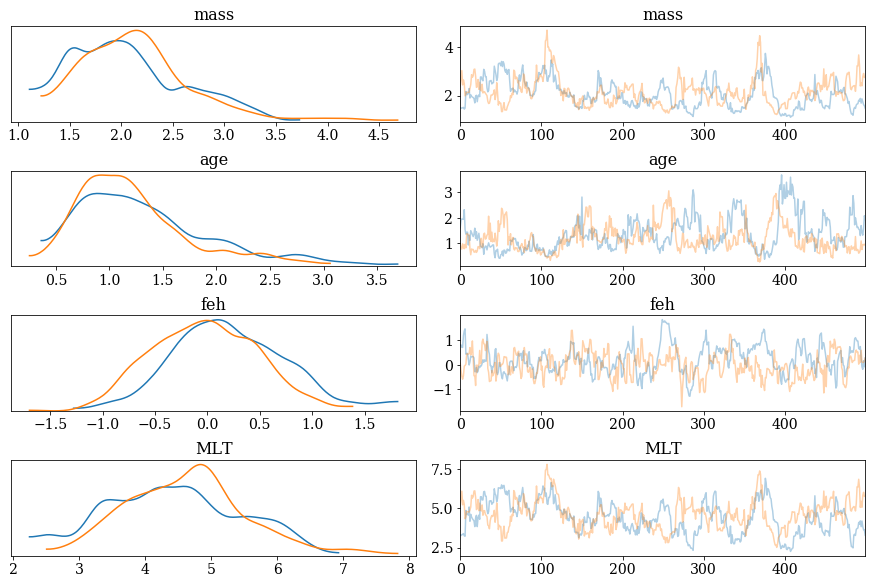

In [63]:
pm.plots.traceplot(trace,var_names=['mass','age','feh','MLT'])

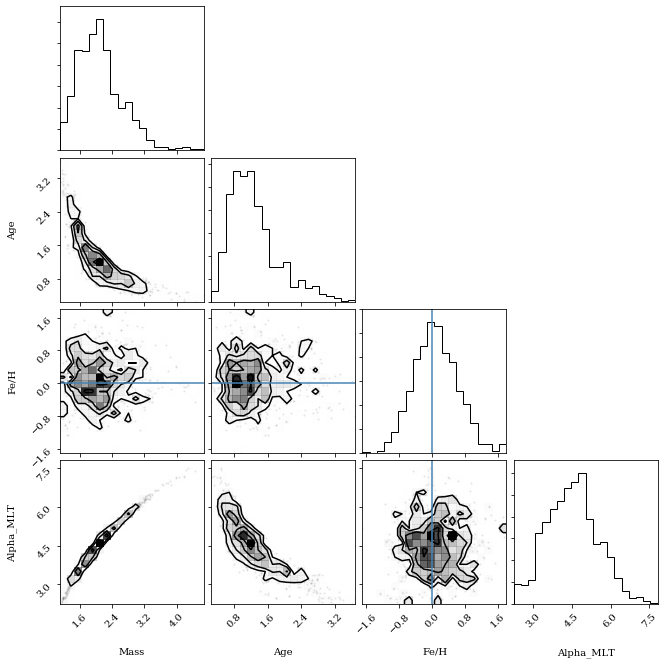

In [64]:
import corner
corner.corner(np.array([trace['mass'], trace['age'], trace['feh'], trace['MLT']]).T, truths=[1.0, 4.5, 0, 1.9],
             labels=['Mass', 'Age', 'Fe/H', 'Alpha_MLT']);

In [43]:
m1.getWeights()
weights=m1.model.get_weights()

def manualPredict(inputs):
    #input shape = 1D array with length as number of NN inputs
    no_hidden_layers = len(weights)/2-1
    xx=inputs
    for i in np.arange(0,no_hidden_layers)*2:
        i=int(i)
        xx=T.nnet.relu(pm.math.dot(xx,weights[i])+weights[i+1],0)
    xx=pm.math.dot(xx,weights[-2])+weights[-1]
    return xx.T

model = pm.Model()
with model:
    
    log_m = pm.Normal('log_mass',np.log10(1),0.1)
    log_a = pm.Normal('log_age',np.log10(4.5),0.1)
    feh = pm.Normal('feh',0,0.1)
    MLT = pm.Normal('MLT',1.9,0.1)
    
    obs = pm.Deterministic('obs',manualPredict([log_m, log_a, feh, MLT]))
    
    obs_L = pm.Normal('obs_L',10**obs[0],0.1, observed=1.0)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1],70, observed=5777)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],15, observed=135)

start = {'log_m': 0.8, 'log_a': 2.5, 'feh':0.1, 'MLT':1.8}
with model:
    trace = pm.sample(start=start)

pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [MLT, feh, log_age, log_mass]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 2000/2000 [00:23<00:00, 85.94draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
log_mass,-0.011061,0.013308,0.000599,-0.037086,0.013443,426.706532,0.999548
log_age,0.673482,0.101491,0.003886,0.499795,0.889700,633.840373,0.999262
feh,0.003932,0.094595,0.003680,-0.181363,0.178499,630.001959,0.999056
MLT,1.912891,0.097209,0.004113,1.728056,2.107051,484.647760,1.000275
obs__0,-0.022664,0.035758,0.001031,-0.091084,0.044491,1287.623362,0.999002
obs__1,3.765366,0.003647,0.000106,3.758229,3.772409,1157.755607,0.999122
obs__2,2.151249,0.015940,0.000511,2.122066,2.186438,1066.791675,0.999066
